## Predictive models for NFL games to enable spread betting.

### Load packages and data files

In [6]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score
from sklearn.preprocessing import StandardScaler
from scipy.stats.mstats import winsorize

In [7]:
# regression model packages
import xgboost as xgb
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor

In [8]:
#import data
merged_df = pd.read_csv('../data/nfl_games_pfr_features.csv')
print(merged_df.columns)

#Separate played and upcoming games
merged_played = merged_df[~merged_df['Margin Yds'].isna()]
merged_upcoming = merged_df[merged_df['Margin Yds'].isna()]


Index(['Unnamed: 0', 'Day', 'Date', 'Time', 'Winner', 'LoserIsHome', 'Loser',
       'PtsW', 'PtsL', 'YdsW', 'TOW', 'YdsL', 'TOL', 'season', 'week',
       'Winner Abbr', 'Loser Abbr', 'Home Team', 'Away Team', 'Home Score',
       'Away Score', 'Winner Yds', 'Loser Yds', 'Margin Yds', 'Winner TO',
       'Loser TO', 'Margin TO', 'Margin Pts', 'Total Pts', 'Margin Pct',
       'home_team_winner', 'away_win_bonus', 'DateTime',
       'DaysSinceLastGame_Home', 'DaysSinceLastGame_Away', 'Home_DefenseRank',
       'Home_OffenseRank', 'Home_ScoreRank', 'Week', 'Away_DefenseRank',
       'Away_OffenseRank', 'Away_ScoreRank', 'Spread', 'Delta_OffenseRank',
       'Ratio_OffenseRank', 'Delta_DefenseRank', 'Ratio_DefenseRank',
       'Delta_ScoreRank', 'Ratio_ScoreRank', 'intTerm1', 'intTerm2',
       'intTerm3', 'intTerm4', 'quadTerm1', 'quadTerm2', 'quadTerm3',
       'quadTerm4', 'HomeStrength', 'AwayStrength', 'Home_Impact',
       'Away_Impact', 'Impact', 'ImpactNeg', 'Differential_Home',


## Make next weeks predictions

In [9]:
filtered_played = merged_played[(merged_played['Delta_ScoreRank'].abs() >= 0.000) & (merged_played['week'] < 17)]

"""
feature_columns = [
    'Ratio_ScoreRank','Impact', 'Differential'
]
"""


feature_columns = ['Ratio_ScoreRank', 'Ratio_OffenseRank', 'Ratio_DefenseRank', 
                'intTerm1', 'intTerm2', 'intTerm3', 'intTerm4', 'quadTerm1', 'quadTerm2', 'quadTerm3', 'quadTerm4', 
                'DaysSinceLastGame_Home', 'DaysSinceLastGame_Away', 'HomeStrength', 'AwayStrength','Home_Impact','Away_Impact', 'Impact',
                'Differential_Home', 'Differential_Away', 'Differential']


# Select features and target variable
X = filtered_played[feature_columns]
y = filtered_played['Spread']

# Define ensemble models
models = [
    ('Ridge1.0', Ridge(alpha=1.0)),
    ('XGBoost0.5', xgb.XGBRegressor(objective='reg:squarederror', n_estimators=50, learning_rate=0.05, max_depth=3, random_state=42)),
    ('RF10', RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)),
]

# Train all models in the ensemble
trained_models = []
for model_name, model in models:
    print(f"Training {model_name}...")
    model.fit(X, y)
    trained_models.append((model_name, model))

# Prepare the data for upcoming games
X_new = merged_upcoming[feature_columns]

# Make ensemble predictions (simple averaging)
ensemble_predictions = np.zeros(len(X_new))
for model_name, model in trained_models:
    predictions = model.predict(X_new)
    ensemble_predictions += predictions

# Average the predictions
y_pred_new = ensemble_predictions / len(trained_models)

print(f"Ensemble of {len(trained_models)} models trained successfully!")

# Assign predictions to the merged_upcoming DataFrame (using .loc to avoid SettingWithCopyWarning)
merged_upcoming = merged_upcoming.assign(Predicted_Spread=y_pred_new)

# Get only the current week's games (assuming it's the latest week)
current_week = merged_upcoming['Week'].max()
current_week_games = merged_upcoming[merged_upcoming['Week'] == current_week]

print(f"Week {current_week} Games ({len(current_week_games)} games):")
print("=" * 60)

# Save predictions to CSV file
current_week_games[['Week','Home Team', 'Away Team', 'Delta_ScoreRank', 'Predicted_Spread']].to_csv('predictions.csv', index=False)

# Print the selected columns for current week only
print(current_week_games[['Week','Home Team', 'Away Team', 'Delta_ScoreRank', 'Predicted_Spread']])

Training Ridge1.0...
Training XGBoost0.5...
Training RF10...
Ensemble of 3 models trained successfully!
Week 10.0 Games (14 games):
     Week Home Team Away Team  Delta_ScoreRank  Predicted_Spread
103  10.0       DEN        LV          0.03057          8.571616
104  10.0       IND       ATL          0.02075          6.937205
105  10.0       MIA       BUF         -0.01360         -4.156562
106  10.0       NYJ       CLE         -0.01471          1.025912
107  10.0       HOU       JAC         -0.01646          7.768990
108  10.0       CAR        NO          0.02130          5.425442
109  10.0        TB        NE          0.01553         -0.296566
110  10.0       CHI       NYG         -0.02551          3.092305
111  10.0       MIN       BAL          0.01518          1.807361
112  10.0       SEA       ARI          0.02623          8.923260
113  10.0       WAS       DET         -0.01572         -4.120117
114  10.0        SF       LAR          0.00998         -1.838083
115  10.0       LAC    

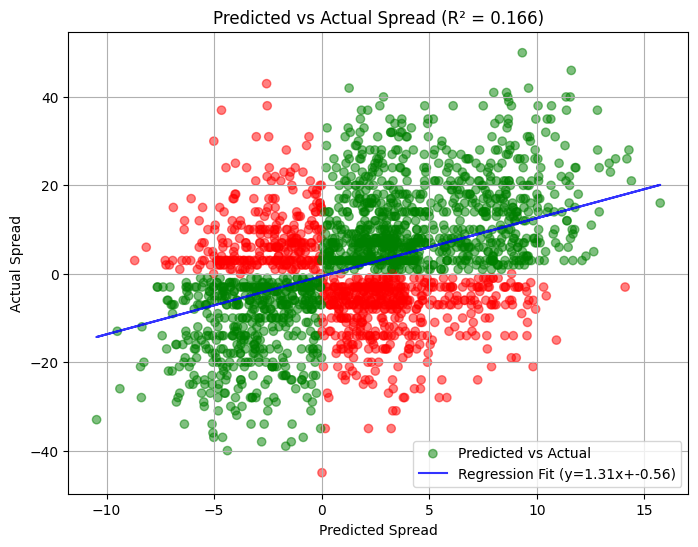

In [10]:
# Make ensemble predictions for the training data to evaluate fit
ensemble_fit_predictions = np.zeros(len(X))
for model_name, model in trained_models:
    predictions = model.predict(X)
    ensemble_fit_predictions += predictions

y_pred_fit = ensemble_fit_predictions / len(trained_models)

colors = np.where((y > 0) & (y_pred_fit > 0) | (y < 0) & (y_pred_fit < 0), 'green', 'red')
# colors = 'black'

# Assuming y_pred_fit is already predicted and y contains actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_fit, y, alpha=0.5, c=colors, label='Predicted vs Actual')

# Add actual regression fit line
z = np.polyfit(y_pred_fit, y, 1)
p = np.poly1d(z)
plt.plot(y_pred_fit, p(y_pred_fit), 'b-', alpha=0.8, label=f'Regression Fit (y={z[0]:.2f}x+{z[1]:.2f})')

# Calculate R² value
r2 = r2_score(y, y_pred_fit)

plt.xlabel('Predicted Spread')
plt.ylabel('Actual Spread')
plt.title(f'Predicted vs Actual Spread (R² = {r2:.3f})')
plt.legend()
plt.grid(True)
plt.show()
